# LEGAL_BERT_v2
---
Master Thesis Project, University of Groningen

By Miriam C. Weigand, June 2024

## Contents 
---

This notebook goes into the creation of a topic model using [BERTopic](https://maartengr.github.io/BERTopic/index.html) and a language model trained on legal data called [LEGAL-BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased). The main focus of this notebook is to fine-tune the model further and create insightful visualisations on ethical concepts of accountabilty in AI regulatory frameworks. 

The structure is as follows:

1. Fine-tuning the model by experimenting with different hyperparameters

2. Calculating the coherence score

3. Illustrate the results with visualisations

## 1. Fine-tuning the model
---

In order to fine-tune the model, it is good to take a look at BERTopic's [Best Pratices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html).

The very first thing we may want to do is precalculate the embeddings. This is because creating embeddings is computationally expensive. Therefore, by pre-calculating them, we avoid having to redo them whenever we are retraining the model. Let's start by loading our dataset (all the steps of the pre-processing were already taken in the [previous model notebook BERTopic_v1.ipynb](https://nbviewer.org/github/v1alina/thesis/blob/main/BERTopic_v1.ipynb) and can be viewed there). 

In [3]:
# Importing the data 
filepath = 'corpus/paragraphs-all'

with open(filepath, "r") as out:
    paragraphs = out.read()
    paragraphs_all = paragraphs.split('\n')

len(paragraphs_all) # To check that we have all paragraphs

23633

The next step is to pre-calculate the embeddings so that it is possible to train the model again while fine-tuning the parameters. However, I encountered a problem. While pre-calculating embeddings using a sentence transformer, such as [BERTopic's default embedding model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), is fairly easy as one can simply use the `encode` method, this is not the case for other language models that are not sentence transformers. I attempted to [pre-calulate the embeddings using the code by Kushal Shah](https://bekushal.medium.com/how-to-find-sentence-similarity-using-transformer-embeddings-bert-vs-sbert-cb7b331c6a09) but this unfortuntely did not work. 

For this reason, I am using BERTopic's default sentence transformers to get the fine-tuning process started.

In [9]:
from sentence_transformers import SentenceTransformer


In [11]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(paragraphs_all, show_progress_bar=True)

Batches:   0%|          | 0/739 [00:00<?, ?it/s]

In [14]:
import umap 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

First, let's look at optimizing some parameters for the dimensionality reduction algorithm UMAP:

The graphs below show the different UMAP result when fine-tuning the n_neighbors (nearest neighbor) parameter. The code is taken from a [tutorial on Basic UMAP Parameters](https://umap-learn.readthedocs.io/en/latest/parameters.html). The n_neighbors paramter influences how the local versus global structure in the data are valued. A small n_neighbors value focues a lot on the local structures, whereas setting it to a high value favors the global structure of the data.

In [15]:
fit = umap.UMAP()
%time u = fit.fit_transform(embeddings)

CPU times: user 29 s, sys: 1.71 s, total: 30.7 s
Wall time: 10.3 s


/opt/anaconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. 

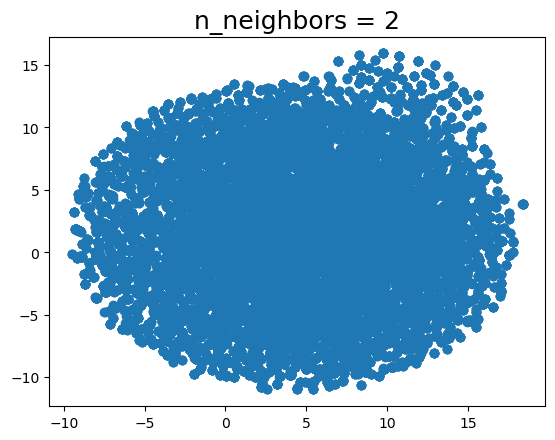

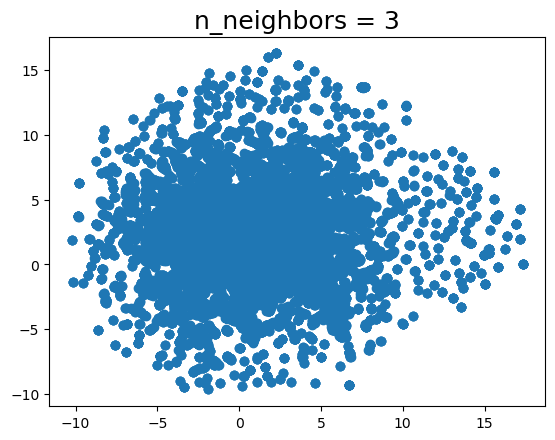

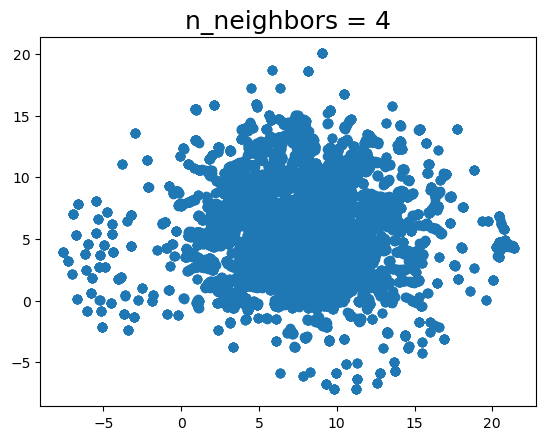

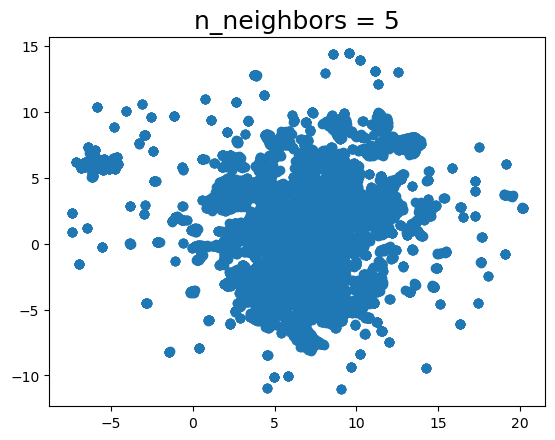

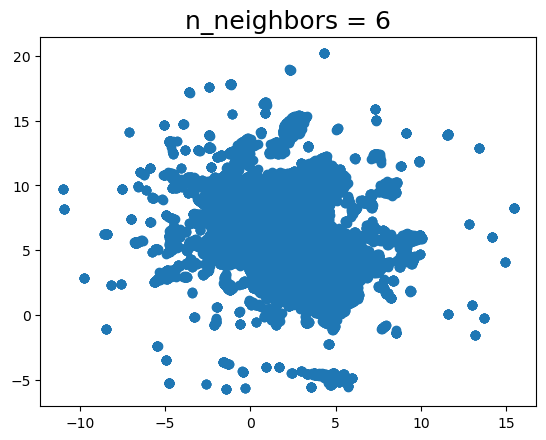

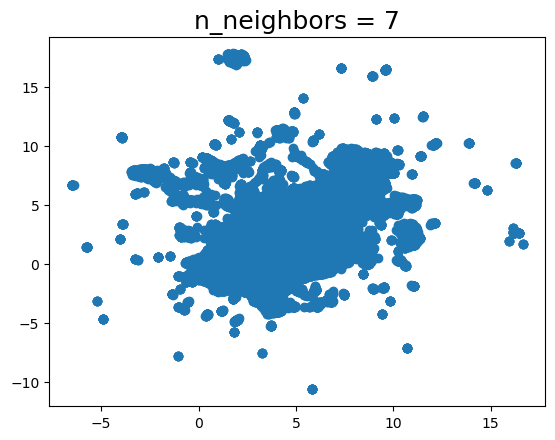

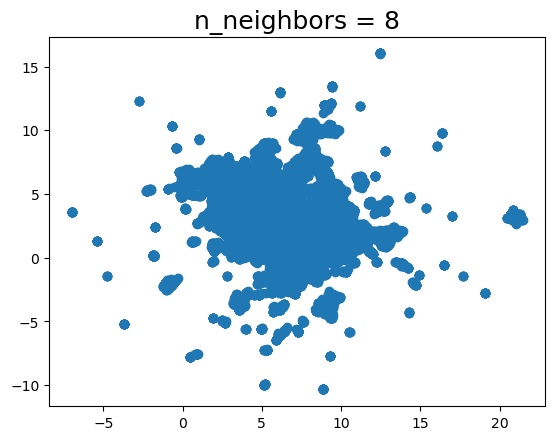

In [24]:
data = embeddings 

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

for n in (2, 3, 4, 5, 6, 7, 8):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

We can see from these graphs that the data is very easily clustered together even at relatively low n_neighbors values. It seems that setting the value to 4 or 5 results in some distincter clusters forming as compared to the other graphs, which are either too spread out or too dense.

Next, the `min_dist` parameter determines how closely data can be clustered together. Setting this parameter to a low value allows points to be clustered densely together, whereas picking a higher value forces UMAP to spread the points further apart.

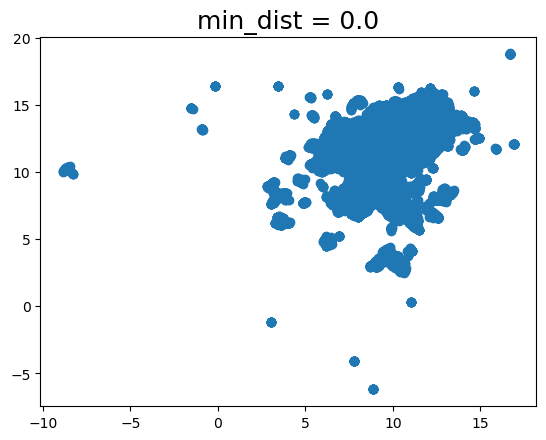

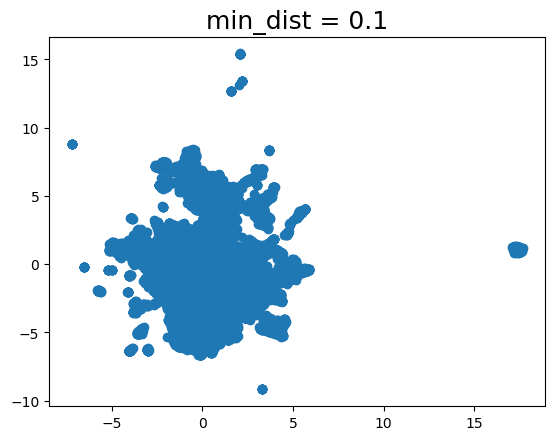

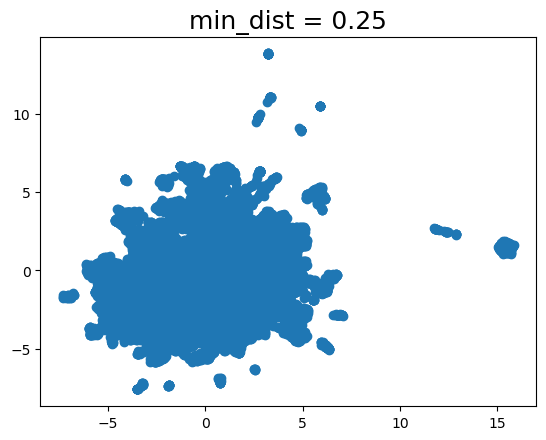

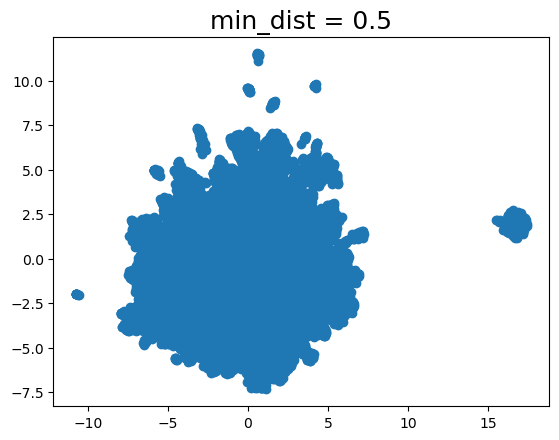

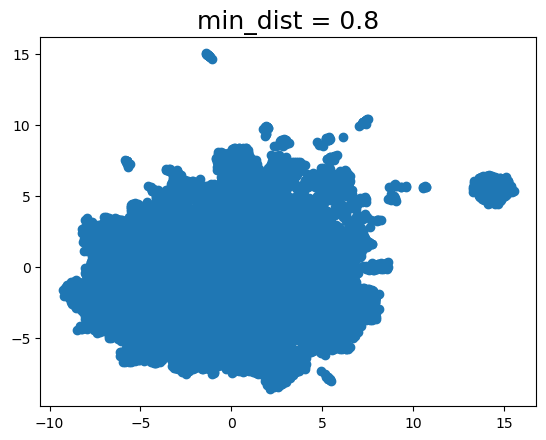

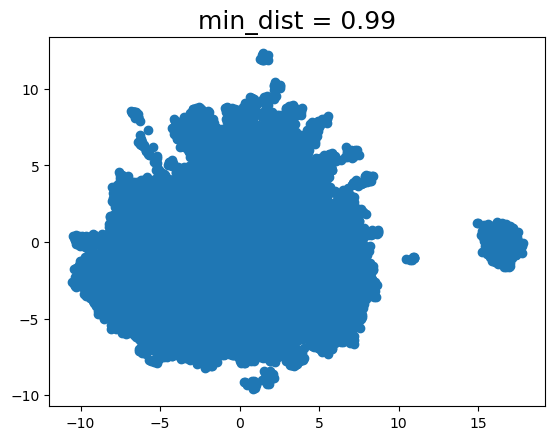

In [25]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

Again it seems that the data is very densely clustered in the center. However, `min_dist =0.25` and `min_dist =0.50` show some more distinct clusters forming. I will therefore pick a value between those two and an `n_neighbors` value of 5 for the UMAP algorithm.

Next, it is possible to filter out rarely used words using the vectorizer. By setting the `min_df=2`, we tell the vectorizer to not count in any words that only appear in less that two documents of the corpus. 

Further, during the weighting scheme it is possibly to strengthen certain representation words to make them more likely to appear in topics by setting them as [seed words](https://maartengr.github.io/BERTopic/getting_started/seed_words/seed_words.html). In order to heighten the relevant topics pertaining to the thesis, I decided set the seed words to "accountability", "responsibility", "transparency", and "explainability". 

In [26]:
# Importing the necessary libraries
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from transformers import AutoTokenizer, AutoModel
from bertopic.representation import KeyBERTInspired
import pandas as pd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
# Step 1: Embedding
embedding_model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased") # Using LEGAL-BERT

# Step 2: UMAP
umap_model = UMAP(n_neighbors=5,
            min_dist=0.30,
            metric='cosine',
            random_state=40 # for reproducibility
                 )

# Step 3: HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size =20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4: Vectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2)

# Step 5: CTF-IDF
ctfidf_model = ClassTfidfTransformer(
    seed_words=["accountability", "responsibility", "transparency", "explainability"], 
    seed_multiplier=2)

# Step 6: optional optimization
representation_model = KeyBERTInspired()

topic_model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model, representation_model = representation_model)
topics, probs = topic_model.fit_transform(paragraphs_all)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [29]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0       -1   7667       -1_ai_governance_infrastructure_technologies   
1        0    754                    0_ai_africa_african_initiatives   
2        1    688                  1_gdpr_data_privacy_anonymisation   
3        2    478      2_agencies_rulemaking_algorithmic_enforcement   
4        3    425                                              3____   
..     ...    ...                                                ...   
299    298     10                   298_neural_networks_patents_deep   
300    299     10             299_risks_risk_confounders_reliability   
301    300     10   300_attacks_vulnerabilities_vulnerability_attack   
302    301     10  301_collaboration_collaborations_collaborative...   
303    302     10    302_code_implementing_compliance_implementation   

                                        Representation  \
0    [ai, governance, infrastructure, technologies,...   
1    [ai, africa, african, initiatives, institution...   
2    [gdpr, data, privacy, anonymisation, regulatio...   
3    [agencies, rulemaking, algorithmic, enforcemen...   
4                                 [, , , , , , , , , ]   
..                                                 ...   
299  [neural, networks, patents, deep, learning, ne...   
300  [risks, risk, confounders, reliability, avoid,...   
301  [attacks, vulnerabilities, vulnerability, atta...   
302  [collaboration, collaborations, collaborative,...   
303  [code, implementing, compliance, implementatio...   

                                   Representative_Docs  
0    [In  particular, data sets should take into ac...  
1    [White Paper: Regulation and Responsible Adopt...  
2    [(GDPR Article   ( ))   Data controller  Data ...  
3    [Government by Algorithm: Artificial Intellige...  
4                                [. . ., . . ., . . .]  
..                                                 ...  
299  [The availability of significantly larger amou...  
300  [These practices include a systematic risk pla...  
301  [Known vulnerabilities  Establishing a taxonom...  
302  [Tim Green; ZZZ University; Subawardee  . Coll...  
303  [( ) The codes of practice should represent a ...  

[304 rows x 5 columns]

After creating the model, it may be interesting to check the #1 topic associated with accountability:

In [38]:
similar_topics, similarity = topic_model.find_topics("accountability", top_n=5)
topic_model.get_topic(similar_topics[0])

[('ai', 0.6101886),
 ('accountability', 0.5847038),
 ('accountable', 0.49357158),
 ('responsibility', 0.44649744),
 ('responsible', 0.41360688),
 ('responsibilities', 0.39022392),
 ('oversight', 0.37923658),
 ('systems', 0.32953793),
 ('liable', 0.31325153),
 ('traceability', 0.2976599)]

The topic seems to capture an interesting dynamic between accountabilty and responsibilty, indicating that the topic model has created insightful topics pertaining to the thesis' topic. 

As the last step of this process, I will save this model to reproduce the result later and compare different optimizations of Topic Models. The model is saved using Pickle. While Pickle is the most costly saving option in terms of memory, it is the only serialization option that retains the `Representative_Docs` column. As this column contains quite some useful information that helps contextualize key terms, I therefore decided to use Pickle.

In [39]:
# Saving the model using Pickle
topic_model.save("LEGAL_BERT_v2", serialization="pickle")

2024-06-17 13:58:28,808 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can load the model anew anytime we want to explore the the topic model again:

In [40]:
# Load model
topic_model = BERTopic.load("LEGAL_BERT_v2")

## 2. Model coherence
---

Topic models are evaluated accross different dimensions. One of them is coherence. 
To compare results and optimize topic models accordingly, we will check the coherence score of each model.

The `c_v` measure for coherence was introduced by [Röder et. al (2012)](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). Why this measurement is used and what it tells us, is discussed further in the thesis.

The code below is taken from a [forum post in the BERTopic GitHub Repository](https://github.com/MaartenGr/BERTopic/issues/90).

In [41]:
cv = topic_model.vectorizer_model
X = cv.fit_transform(paragraphs_all)
doc_tokens = [text.split(" ") for text in paragraphs_all]

import gensim.corpora as corpora
id2word = corpora.Dictionary(doc_tokens)
texts = doc_tokens
corpus = [id2word.doc2bow(text) for text in texts]

topic_words = []
for i in range(len(topic_model.get_topic_freq())-1):
  interim = []
  interim = [t[0] for t in topic_model.get_topic(i)]
  topic_words.append(interim)

from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(topics=topic_words, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')

print("Coherence score:", coherence_model.get_coherence())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Coherence score: 0.4215103772352184


## 3. Model visualization and interpretation
---

Let us first look at the main keyword we are interested in 'accountability'.
First, we use one of BERTopic's inbuilt functions `find_topics` in order to find the top 4 topics most related to our keyword.

In [44]:
accountability_topics, similarity = topic_model.find_topics("accountability", top_n=4)
topic_model.get_topic(accountability_topics[0])

[('ai', 0.6101886),
 ('accountability', 0.5847038),
 ('accountable', 0.49357158),
 ('responsibility', 0.44649744),
 ('responsible', 0.41360688),
 ('responsibilities', 0.39022392),
 ('oversight', 0.37923658),
 ('systems', 0.32953793),
 ('liable', 0.31325153),
 ('traceability', 0.2976599)]

### Top words per topic related to accountability

We can already see some of terms associated with the topic most closely related to accountability. 
This is a great start, but in order to get a better overview, let's visualize the top 4 topics and their terms together.

BERTopic has an easy to use method with which we can visualize topics easily. Below I am passing the `accountability_topics` to the method in order to visualize their top words. To make the rendering possibly using the [NBviewer](https://nbviewer.org) the visualization is loaded using `iplot`. This is optional and not necessary of one were to render the visualizations just in the notebook. 

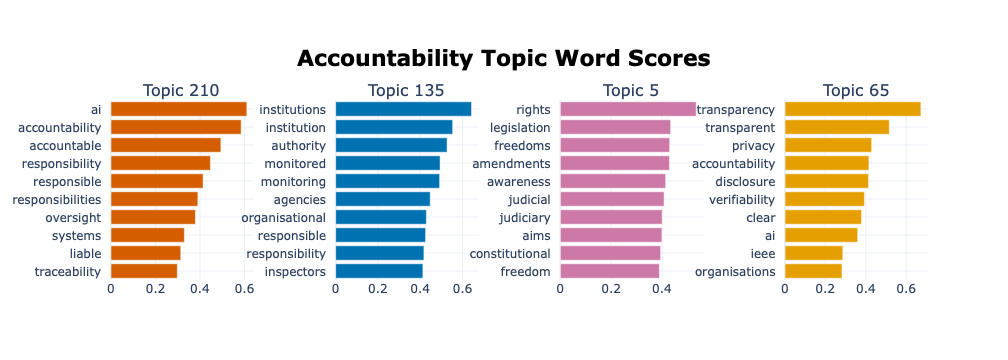

In [45]:
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
init_notebook_mode(connected=True)

fig = topic_model.visualize_barchart(topics = accountability_topics, n_words = 10, title = '<b>Accountability Topic Word Scores</b>')

iplot(fig)

We can go a step further and look at some of the related ethical concepts to accountability in AI regulation. Below, I am getting the top four topics for 'responsibility', 'transparency', and 'explainability' to visualize them together with the top topics for accountability.

In [52]:
# Extracting top 4 topics for ethical principles
responsibility_topics, similarity = topic_model.find_topics("responsibility", top_n=4)
transparency_topics, similarity = topic_model.find_topics("transparency", top_n=4)
explainability_topics, similarity = topic_model.find_topics("explainability", top_n=4)

# Adding all the top topics together into one list to pass to the barchart later
ethics_principles = accountability_topics + responsibility_topics + transparency_topics + explainability_topics

Let's visualize the four ethical principles we have collected the top topics for. Each row of barcharts corresponds to one of the concepts in the following order:
1. Accountability
2. Responsibility
3. Transparency
4. Explainability

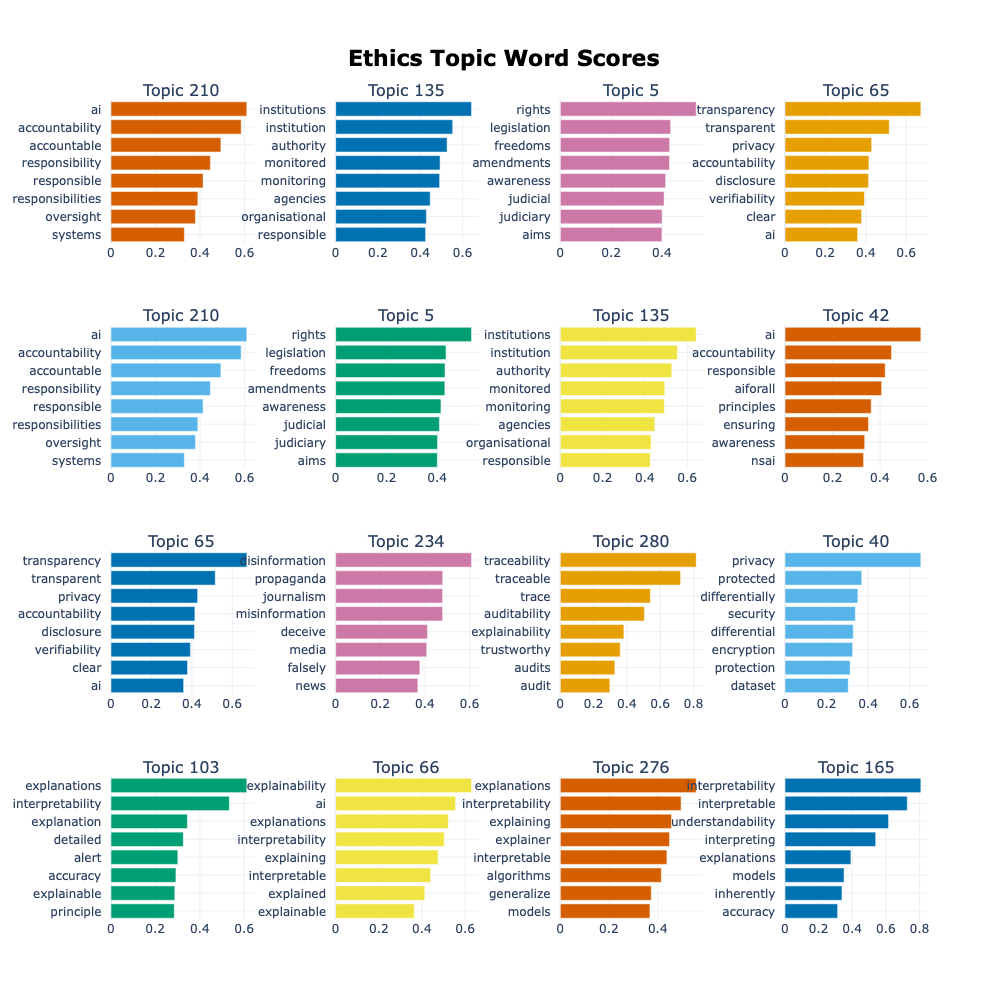

In [55]:
# Visualizing all top 4 topics related to ethical AI principles:
fig_2 = topic_model.visualize_barchart(topics = ethics_principles, n_words = 8, title = '<b> Ethics Topic Word Scores</b>', custom_labels = False)

iplot(fig_2)

### Visualizing the top paragraphs assigned to the accountability topics:

Another useful feature of BERTopic is that the top three documents associated with each topic are saved by the model and can easily be extracted and examined. In the code below, I am saving the model to a Pandas DataFrame. 

Then, the top 3 paragraphs pertaining to the #1 topic of accountability are printed and the topic words highlighted in bold. In this way, we can see the topic of accountability and associated words in a bit more context. 

In [47]:
# Saving the topic model data in a Pandas DataFrame
BERTopic_v1_df = topic_model.get_topic_info()

# Extracting to #1 topic related to accountability from the DataFrame
accountability = BERTopic_v1_df[BERTopic_v1_df['Topic'] == accountability_topics[0]]

# Getting top 3 paragraphs 
rep_docs = accountability['Representative_Docs'].item()

# Getting top representation wordswords 
representation = accountability['Representation'].item()

The function below allows us to us to pass the representative words and top 3 documents of a given topic and print them in a readable format:

In [48]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def display_top_docs(rep_docs, representation):
    counter = 1 # Counting the top documents
    for doc in rep_docs: 
        for word in representation:
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE) #putting all the representative words in bold
                
        make_md(f'**Top document #{counter}**: \n\n*{doc}*\n\n') # Printing the paragraph
        counter += 1

In [50]:
# Displaying top 3 documents for accountability 
display_top_docs(rep_docs, representation)

**Top document #1**: 

*It should be  possible to explain to the end user and other stakeholders in non-technical terms and in plain  language, why, how, where and for what purpose the decisions made based on automatic and  algorithmic decisions, the data leading to said decisions and the information obtained from that  data are used. Responsibility and Accountability Person(s) and organizations involved in the lifecycle of AI **systems** are ultimately **responsible**  for the proper functioning of AI **systems** and the application of AI principles. In line with their roles  in the lifecycle, the context of the system and technological possibilities, these actors and their  ethical **responsibilities** should be able to be related to their liabilities regarding their decisions  and actions.*



**Top document #2**: 

*In the case of decisions signiﬁcantly affecting rights, there should be an effective system of **oversight**, which makes appropriate use of human judgment. Accountability Those **responsible** for the different phases of the AI system lifecycle  should be identiﬁable and **accountable** for the outcomes of the AI **systems**, and human **oversight** of AI **systems** should be enabled. This principle aims to acknowledge the relevant organisations’ and individuals’ **responsibility** for the outcomes of the AI systems that they design, develop, deploy and operate.*



**Top document #3**: 

*b) To this end, AI actors should ensure **traceability** including in  relation to datasets, processes and decisions made during the AI  system lifecycle, to enable analysis of the AI system’s outcomes  and responses to inquiry, appropriate to the context and  consistent with the state of art. c)  AI actors should, based on their roles, the context, and their  ability to act, apply a systematic risk management approach to  each phase of the AI system lifecycle on a continuous basis to  address risks related to AI **systems** including privacy, digital  security, safety and bias. (v)  Accountability - AI actors should be **accountable** for the proper  functioning of AI **systems** and for the respect of the above principles  based on their roles, the context, and consistent with the state of art.*



### Visualizing the topics' distances

Next, it might be interesting to see how the different topics relate and cluster together.

The #1 top topic for accountability is 210. By adjusting the slider at the bottom of the Intertopic Distance Map it is possible to find this topic in a cluster or closely related topics. Some topics of interest in this cluster are topics 82, 65, 117, 280, 4, and 42. 

I visualised the Word Scores for said topics, so it it possible to have a look at a glance what some related topics to accountability are. We can see #1 top topic for transparency again (topic 65). Another interesting one is topic 117, which seems to be about audits. It is interesting to see that a topic on audits appears closely to the main topic for accountability. This is because audits are one potential tool for ensuring accountabilty as discussed in Chapter 2 of the thesis. Next there is topic 280, with the representative words traceablility, auditability, explainability, and trustworthy. This topic seems to pertain to audits as well but more contextualised with the purpose of audits, which is to maintain or gain trust in the AI systems. Topic 4 is also interesting in this regard because it pertains to reasons we may be inclinded to not trust algorithmic systems and AI: fairness, bias, and equality. It is therefore reasonable that these topics are frequently discussed conjointly as one is the reason for the other to emerge.

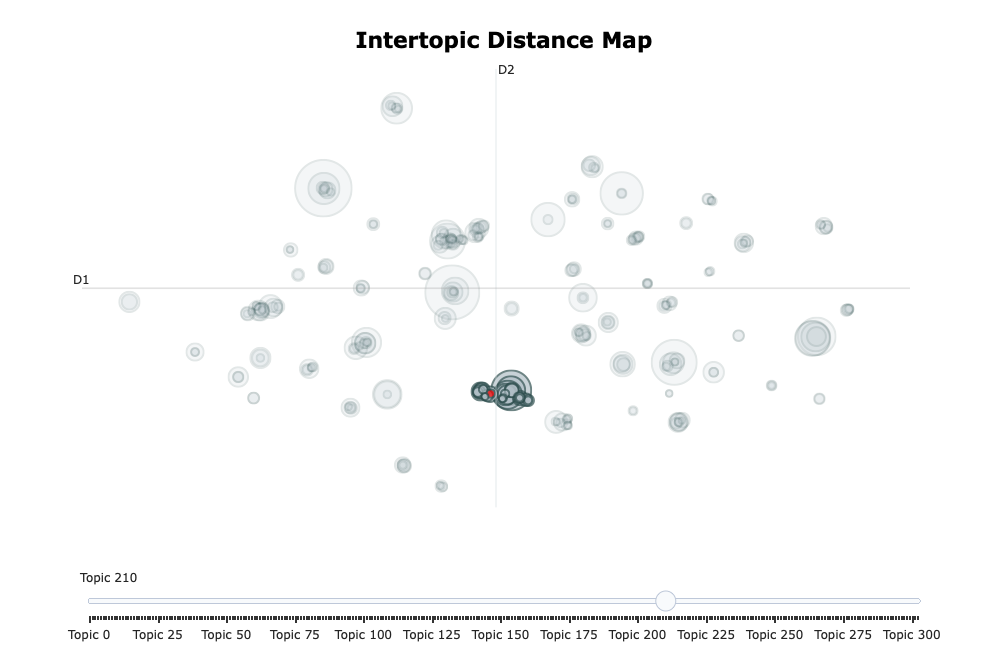

In [56]:
fig_3  = topic_model.visualize_topics()
iplot(fig_3)

Let's visualize some of the interesting topics in the surrounding cluster of topic 210 (top accountabilty topic):

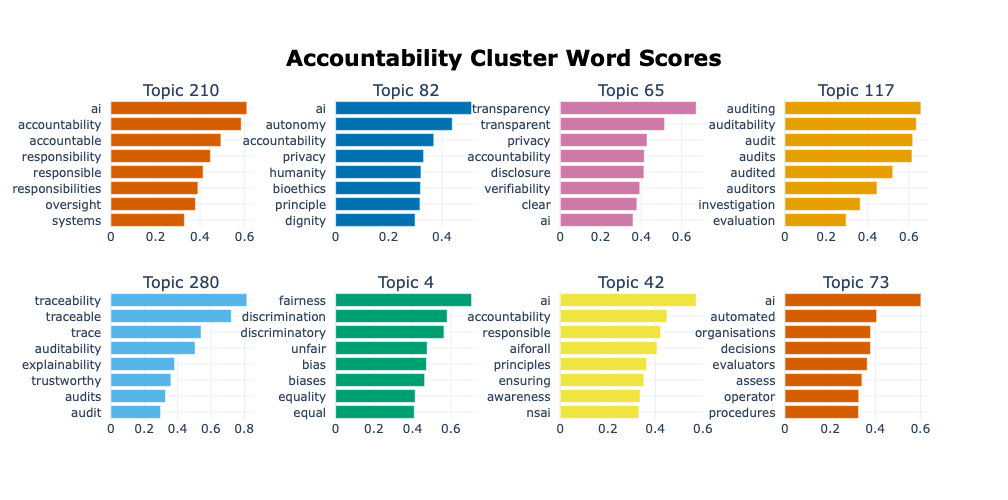

In [61]:
# Visualizing topics in the cluster around topic 210:

accountability_cluster = [210, 82, 65, 117, 280, 4, 42, 73]
fig_4 = topic_model.visualize_barchart(topics = accountability_cluster, n_words = 8, title = '<b> Accountability Cluster Word Scores</b>', custom_labels = False)

iplot(fig_4)

We can see now some of the most striking topics that are placed closely together in a cluster in the Intertopic Distance Map. Through this we can see several distinct but related topics. Some of them pertain to ethical issues such as biases and privacy. Others such as topics 117, 280, and 73 seem to be about auditability and monitoring AI systems. 

Lastly, I though it would be of interest to retrieve some more documents from relevant topics such as topic 65, which pertains to transparency and topic 117, which pertains to auditability. We can see that the preprocessing is not always ideal in these cases and that the sentence tokenizer sometimes struggles with finding well defined sentences. As there are likely a lot of headings and other non-sentence structures in regulatory frameworks, it is difficult to circumvent this issue but important to note nonetheless.

In [58]:
# Extracting to #1 topic related to tansparency from the DataFrame
tansparency = BERTopic_v1_df[BERTopic_v1_df['Topic'] == 65]

# Getting top 3 paragraphs 
rep_docs = tansparency['Representative_Docs'].item()

# Getting top representation wordswords 
representation = tansparency['Representation'].item()

# Displaying top 3 documents for transparency 
display_top_docs(rep_docs, representation)

**Top document #1**: 

*In April  , the AI-HLEG presented a checklist for ensuring **transparency**,  which will be verified through actual demonstrations with companies, and in   published a  self-assessment list of trusted AI [ ], including seven requirements for **transparency** and  **accountability**. The European AI Bill requires transparency and provision of information to users,  which means transparency of operation by design and development of **transparent** operation so  that the user can understand and control the processing process. On the other hand, IEEE is currently examining IEEE P  (transparency of autonomous  systems)[ ] and it may have a certain level of influence over future standardization in terms of  the definitions of terms and concept.*



**Top document #2**: 

*Are there other measures we could require of **organisations** to improve **transparency** for AI? . There was strong support for a range of **transparency** measures from respondents.*



**Top document #3**: 

*. . Transparency  ( ) The **transparency** requirements, specified in section  .*



In [59]:
# Extracting to #1 topic related to audits from the DataFrame
audits = BERTopic_v1_df[BERTopic_v1_df['Topic'] == 117]

# Getting top 3 paragraphs 
rep_docs = audits['Representative_Docs'].item()

# Getting top representation wordswords 
representation = audits['Representation'].item()

# Displaying top 3 documents for audits 
display_top_docs(rep_docs, representation)

**Top document #1**: 

*[Practical Example  ]  We had an independent internal **audit** department for **auditing** the operation of our internal rules before  the introduction of our AI management system. When we introduced the AI management system,  we extended the internal **audit** department’s scope of work to include the AI management system  as one of their audit subjects. At our company, internal **auditors** investigate and check, with the  cooperation of the relevant departments, whether their organizational setup, rules, etc.*



**Top document #2**: 

*Currently, we are considering  enhancing the third-party perspectives, and sharing **audit** results and exchanging opinions at cross-         departmental feedback meetings to communicate that the purpose of these internal **audits** is to make  improvements. [Practical Example  ]  We have an internal **audit** department, but we decided to try making use of external **audits** for our AI  management system. The expectations we have for these external **auditors** are their high levels  of expertise and application of experience that they have gained from their audits of other  companies.*



**Top document #3**: 

*Conducting an algorithm **audit** requires technical expertise which  may require engaging external experts. The **audit** report may be beyond the understanding  of most individuals and organisations. The expense and time required to conduct an  algorithm audit should be weighed against the expected benefits obtained from the  audit report.*

